# QC and processing raw barcode counts for Library 2 with the Rho promoter
This notebook takes raw barcode counts and processes it into activity scores for each replicate. Then, we do statistics to determine which sequences are significantly different from the Rho promoter alone. There are three biological replicates of RNA and one DNA sample from the input plasmid pool. This notebook should be nearly identical to notebook 01 for Library 1 with Rho.

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

sys.path.insert(0, "utils")
from utils import modeling, plot_utils, quality_control

In [2]:
plot_utils.set_manuscript_params()

## Load in data

In [3]:
barcode_count_dir = os.path.join("Data", "Rhodopsin")
barcode_count_files = ["library2Plasmid.counts", "library2Rna1.counts",
                     "library2Rna2.counts", "library2Rna3.counts"]
barcode_count_files = [os.path.join(barcode_count_dir, i) for i in barcode_count_files]

# Stuff for downstream functions
sample_labels = np.array(["DNA", "RNA1", "RNA2", "RNA3"])
sample_rna_mask = np.array([False, True, True, True])
rna_labels = sample_labels[sample_rna_mask]
dna_labels = sample_labels[np.logical_not(sample_rna_mask)]
n_samples = len(sample_labels)
n_rna_samples = len(rna_labels)
n_dna_samples = len(dna_labels)

n_barcodes_per_sequence = 3
results_dir = barcode_count_dir
output_prefix = os.path.join(results_dir, "library2")

all_sample_counts_df = quality_control.read_bc_count_files(barcode_count_files, sample_labels)
all_sample_counts_df.to_csv(f"{output_prefix}RawBarcodeCounts.txt", sep="\t", na_rep="NaN")
all_sample_counts_df.head(20)

,label,DNA,RNA1,RNA2,RNA3
barcode,,,,,
AACAACAAG,chr7-141291911-141292075_UPPP_MUT-allCrxSites,132,0,1,1
AACAACGTT,chr19-16380352-16380516_CPPN_MUT-allCrxSites,1779,36,17,46
AACAACTAC,chr1-44147572-44147736_UPPP_MUT-allCrxSites,2928,433,802,510
AACAACTCG,chr12-116230818-116230982_CPPE_WT,2822,3043,2967,3013
AACAACTGT,chr5-65391346-65391510_CPPP_MUT-allCrxSites,1810,1572,2281,1559
AACAAGCTT,chr15-97965790-97965954_CPPP_MUT-allCrxSites,1047,1259,1531,1310
AACAAGGCG,chr1-59164069-59164233_CPPE_WT,4966,17124,17046,14499
AACAAGTAG,chr2-158513919-158514083_CPPE_WT,2690,10607,12288,9783
AACAAGTCT,chr11-58097684-58097848_UPCP_MUT-allCrxSites,4049,1589,2030,1541


## Threshold barcode counts, assess reproducibility
Set barcodes that are below the DNA cutoff to an NaN (because they are missing from the input plasmid pool) and those that are below any of the RNA cutoffs to zero in all replicates.

Barcodes missing in DNA:
Sample DNA: 277 barcodes
277 barcodes are missing from more than 0 DNA samples.
Barcodes off in RNA:
Sample RNA1: 875 barcodes
Sample RNA2: 678 barcodes
Sample RNA3: 774 barcodes
1180 barcodes are off in more than 0 RNA samples.
There are a total of  157.724 million barcode counts.


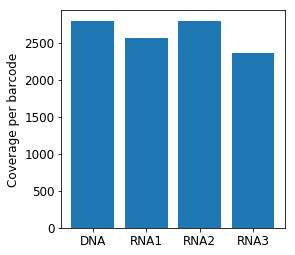

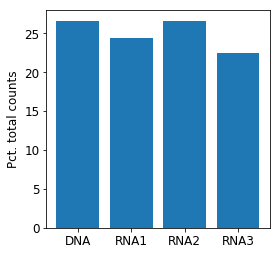

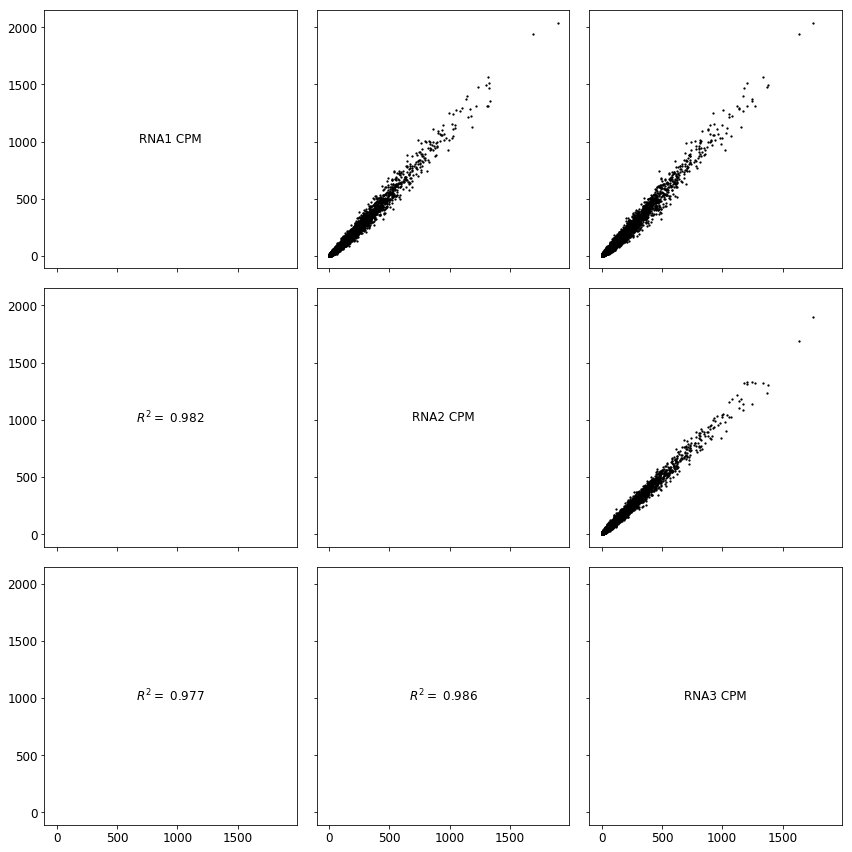

In [4]:
cutoffs = [10, 5, 5, 5]
threshold_sample_counts_df = quality_control.filter_low_counts(all_sample_counts_df, sample_labels, cutoffs,
                                                               dna_labels=dna_labels, bc_per_seq=n_barcodes_per_sequence)
fig = quality_control.reproducibility_plots(threshold_sample_counts_df, rna_labels, "CPM", big_dimensions=True)
plot_utils.save_fig(fig, f"{output_prefix}Reproducibility", timestamp=False)

## Normalize RNA barcode counts by plasmid barcode counts

In [5]:
normalized_sample_counts_df = quality_control.normalize_rna_by_dna(threshold_sample_counts_df, rna_labels, dna_labels)
# Drop DNA
barcode_sample_counts_df = normalized_sample_counts_df.drop(columns=dna_labels)

## Compute expression across replicates

In [6]:
activity_replicate_df = quality_control.average_barcodes(barcode_sample_counts_df)
activity_replicate_df.to_csv(f"{output_prefix}ReplicateExpression.txt", sep="\t", na_rep="NaN")

## Normalize to basal, average across replicates, do statistics

In [7]:
sequence_expression_df = quality_control.basal_normalize(activity_replicate_df, "BASAL")
# Compare vs. basal
sequence_expression_df["expression_pvalue"] = quality_control.log_ttest_vs_basal(activity_replicate_df, "BASAL")
sequence_expression_df["expression_qvalue"] = modeling.fdr(sequence_expression_df["expression_pvalue"])

# Save to file
sequence_expression_df.to_csv(f"{output_prefix}TotalExpressionSummary.txt", sep="\t", na_rep="NaN")

/home/ryan/Documents/DBBS/CohenLab/Manuscripts/CRX-Information-Content/utils/quality_control.py:408: RuntimeWarning: invalid value encountered in double_scalars
  cov = std / mean
